

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>




## PGE 383 Project: Demonstrating the Performance of Gaussian Mixture Models in Clustering Data

#### Mariella El Khoury
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering





_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Lei Liu, Graduate Student, The University of Texas at Austin


### Executive Summary

K-Means clustering is a simple and accurate method for well-separated and isotropic data. However, its limitations become evident when working with non-spherical data, as it lacks flexibility and relies on hard clustering.  To address these challenges, we will introduce Gaussian Mixture Models (GMMs). GMMs excel at clustering data with varying shapes, employs soft clustering, and adapt to clusters with different sizes. This makes GMMs a powerful solution for a broader range of clustering scenarios. In this project, GMMs will be demonstrated through scatter plots to provide an insightful exploration of the method.

### Import Packages

In [321]:
import numpy as np                                        # for working with data and model arrays
from scipy.stats import multivariate_normal               # for multivariate normal random variable.
import matplotlib.pyplot as plt                           # for plotting
import pandas as pd                                       # DataFrames for tabular data

### Declare Functions

The following functions will be used in the workflow to perform the steps required by Gaussian Mixture Models.

* Initialise random gaussian models
* Calculate probability that each data belongs to each gaussian model
* Update the parameters of the gaussian models
* Repeat until convergence

In [333]:
#In my workflow, I have modified code from GeostatsGuy on Github, llSourcell on Github (https://github.com/llSourcell/Gaussian_Mixture_Models) and ChatGPT
def initialize_parameters(X, n_components):
    # X is the data matrix of shape (N, 2), where N is the number of data points.Build Gaussian from our data points
    # n_components is the number of Gaussians expected in the data

    np.random.seed(0) 
    indices = np.random.choice(X.shape[0], n_components, replace=False)
    means = X[indices]
    covariances = [np.cov(X.T) for _ in range(n_components)]
    mixing_coeffs = np.full(n_components, 1/n_components)
    
    return means, covariances, mixing_coeffs

def e_step(X, means, covariances, mixing_coeffs):
    # X is the data matrix, means, covariances, and mixing_coeffs are the parameters
    responsibilities = np.zeros((X.shape[0], len(mixing_coeffs)))

    for i, (mean, cov, mixing_coeff) in enumerate(zip(means, covariances, mixing_coeffs)):
        # Calculate the probability density function for each point
        rv = multivariate_normal(mean, cov)
        responsibilities[:, i] = mixing_coeff * rv.pdf(X)

    # Normalize the responsibilities so that they sum to 1 for each data point
    responsibilities_sum = responsibilities.sum(axis=1)[:, np.newaxis]
    responsibilities /= responsibilities_sum

    return responsibilities

def m_step(X, responsibilities):
    # X is the data matrix and responsibilities are the current responsibilities
    n_components = responsibilities.shape[1]
    n_features = X.shape[1]
    Nk = responsibilities.sum(axis=0)  # Sum of responsibilities for each component

    # Update means
    means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
    
    # Update covariances
    covariances = []  
    for j in range(n_components):
        diff = X - means[j]
        weighted_diff = responsibilities[:, j][:, np.newaxis] * diff
        cov = np.dot(weighted_diff.T, diff) / Nk[j]
        covariances.append(cov)
    
    # Update mixing coefficients
    mixing_coeffs = Nk / X.shape[0]                             

    return means, covariances, mixing_coeffs

def compute_log_likelihood(X, means, covariances, mixing_coeffs):
    # Compute the log likelihood of the data given the current parameters
    log_likelihood = 0
    for mean, cov, mixing_coeff in zip(means, covariances, mixing_coeffs):
        rv = multivariate_normal(mean, cov)
        log_likelihood += mixing_coeff * rv.pdf(X)
    return np.log(log_likelihood).sum()

def gmm_fit(X, n_components, tol=1e-4, max_iter=100): 
    means, covariances, mixing_coeffs = initialize_parameters(X, n_components)
    log_likelihood_old = 0
    tolerance = np.zeros(100)

    for iteration in range(max_iter):
        # E-step
        responsibilities = e_step(X, means, covariances, mixing_coeffs)
        
        # M-step
        means, covariances, mixing_coeffs = m_step(X, responsibilities)
        
        # Check for convergence < tol
        log_likelihood_new = compute_log_likelihood(X, means, covariances, mixing_coeffs)
        tolerance[iteration] = log_likelihood_new - log_likelihood_old
        #tolerance = numpy.array
        if np.abs(log_likelihood_new - log_likelihood_old) < tol: 
            break
        log_likelihood_old = log_likelihood_new
        
        #Plot at iteration 2
        if iteration == 2:
            plt.subplot(221)
            plt.scatter(X[:,0], X[:,1], c=responsibilities.argmax(axis=1), cmap='viridis')
            for mean, cov in zip(means, covariances):
                rv = multivariate_normal(mean, cov)
                plt.contour(x, y, rv.pdf(pos), levels=3, linewidths=1.5)
            plt.title('GMMs at iteration 2')
            plt.xlabel('TOC')
            plt.ylabel('Brittle')
        
        #Plot at iteration 9
        if iteration == 9:
            plt.subplot(222)
            plt.scatter(X[:,0], X[:,1], c=responsibilities.argmax(axis=1), cmap='viridis')
            for mean, cov in zip(means, covariances):
                rv = multivariate_normal(mean, cov)
                plt.contour(x, y, rv.pdf(pos), levels=3, linewidths=1.5)
            plt.title('GMMs at iteration 9')
            plt.xlabel('TOC')
            plt.ylabel('Brittle')
            
        #Plot at iteration 12
        if iteration == 12:
            plt.subplot(223)
            plt.scatter(X[:,0],X[:,1], c=responsibilities.argmax(axis=1), cmap='viridis')
            for mean, cov in zip(means,covariances):
                rv = multivariate_normal(mean, cov)
                plt.contour(x, y, rv.pdf(pos), levels=3, linewidths=1.5)
            plt.title('GMMs at iteration 12')
            plt.xlabel('TOC')
            plt.ylabel('Brittle')
            
        plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
            
    print('The number of iterations is:', iteration)
    return means, covariances, mixing_coeffs, tolerance, responsibilities

### Load Data

The following workflow applies the .csv file 'synthetic_data', a synthetic dataset generated using the code by Dr. Michael Pyrcz's repository. The code used is available on Github. 
(https://github.com/GeostatsGuy/PythonNumericalDemos)  

We will work with the following features:

* **TOC** - the total amount of carbon within organic compounds in subsurface formations
* **Brittlness** - refers to the propensity of rock or shale to fracture under stress

In [323]:
df = pd.read_csv('d:/Subsurface ML/synthetic_data.csv')   # load the comma delimited data file 
df = df.iloc[:,[1,2,3]]                                   # extract TOC and brittleness for a simple 2D example
df.head()                                                 # preview the new DataFrame

,TOC,Brittle,Facies
0,7.123876,676.646053,3
1,11.152390,762.414377,3
2,7.243799,614.738989,3
3,11.501253,900.000000,3
4,8.279366,708.633220,3


When the data is visualised, we can observe that the data values are not compatible. Therefore, we will normalise our data. 

In [324]:
TOCmin = df['TOC'].min(); TOCmax = df['TOC'].max()      # Values of TOC and Brittleness are normalised. 
Brittlemin = df['Brittle'].min(); Brittlemax = df['Brittle'].max()

df['Norm_TOC'] = (df['TOC']-TOCmin)/(TOCmax - TOCmin)
df['Norm_Brittle'] = (df['Brittle']-Brittlemin)/(Brittlemax - Brittlemin)


df_subset = df.iloc[:,[0,1,2,3,4]]              # extract Brittleness and Afor a simple 2D example
df_subset.head()                                # preview the new DataFrame

,TOC,Brittle,Facies,Norm_TOC,Norm_Brittle
0,7.123876,676.646053,3,0.237463,0.560207
1,11.152390,762.414377,3,0.371746,0.632281
2,7.243799,614.738989,3,0.241460,0.508184
3,11.501253,900.000000,3,0.383375,0.747899
4,8.279366,708.633220,3,0.275979,0.587087


Now, let's visualise our data on cross plots.

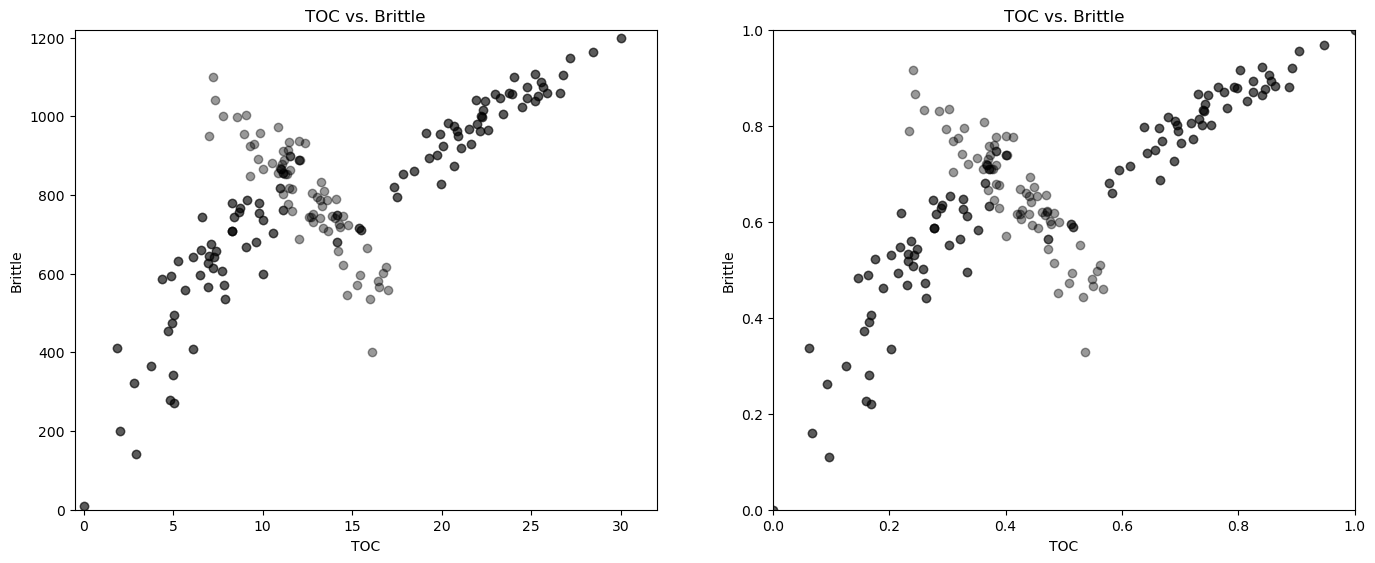

In [325]:
TOC_min = -0.5; TOC_max = 32
Brittle_min = 0; Brittle_max = 1220
np.random.seed(0)
colmap = {1: 'r', 2: 'g', 3: 'b', 4: 'm', 5: 'c', 6: 'k', 7: 'w'}

# scatter plot our training data  
plt.subplot(121)
plt.scatter(df_subset['TOC'], df['Brittle'], c="black", alpha = 0.4, linewidths=1.0, edgecolors="black")
plt.title('TOC vs. Brittle'); plt.xlabel('TOC'); plt.ylabel('Brittle')
plt.xlim(TOC_min, TOC_max)
plt.ylim(Brittle_min, Brittle_max)

plt.subplot(122)
plt.scatter(df_subset['Norm_TOC'], df['Norm_Brittle'], c="black", alpha = 0.4, linewidths=1.0, edgecolors="black")
plt.title('TOC vs. Brittle'); plt.xlabel('TOC'); plt.ylabel('Brittle')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

### Gaussian Mixture Models (GMMs)

GMMs is a probabilistic model that uses the soft clustering approach to assign data to clusters. This method uses an Expectation-Maximization approach. 

This workflow is broken up to the primary steps of:
### Step 1:The Initialisation of Gaussian Distribution
Initialise K random gaussian distributions. This is done by initialising parameters for each distribution:
* The mean vector ('μ') for each Gaussian. 
* The covariance matrix ('ε') which indicates the shape of the Gaussian. 
* The mixing coefficient ('π') for each Gaussian which indicates the prior probability that a point comes from that Gaussian.

### Step 2: The Expectation Step (E-Step)
Calculate the probability (responsibility) that each point belongs to each Gaussian distribution. 
This is calculated using the multivariate Gaussian density function:

$\Large\begin{equation}
N(x|μ,ε) = \frac{1}{2π^{\frac{d}{2}}sqrt(|ε|)}exp\Bigg[\frac{-1}{2}(x-μ)^{T}∑^{-1}(x-μ)\Bigg]
\end{equation}$

* x is a data point
* μ is the mean of the Gaussian distribution
* ε is the covariance matrix of the Gaussian 
* d is the dimensionality of the data

This probability is calculated to compute the responsibilities:

$\Large\begin{equation}
r =  \frac{πN(x|μ,ε)}{∑_{k=1}^{K}πN(xμ,ε)}
\end{equation}$

* r is the responsibility of Gaussian for a data point
* K is the number of gaussian distributions

### Step 3: The Maximization Step (M-Step) 
Update the parameters for each Gaussian using the responsibilities calculated in the E-Step. The new parameters are calculated as follows:
* the new means μ for each Gaussian:

$\Large\begin{equation}
μ_{new} = \frac{1}{N_{j}}∑_{i=1}^{N}(rx) 
\end{equation}$

* the new covariance matrice ε for each Gaussian:

$\Large\begin{equation}
ε_{new} = \frac{1}{N_{j}}∑_{i=1}^{N}r_{ij}(x_i-μ_{new})(x_{i}-μ_{new})^{T} 
\end{equation}$

* New mixing coefficient π for each Gaussian:

$\Large\begin{equation}
π_{new} = \frac{N_{j}}{N}
\end{equation}$

Nj is the effective number of points assigned to a Gaussian. 

### Step 4: The Convergence Criteria: 

Repeat the E and M Steps until convergence. This means that the change in the likelihood of the data is under a threshold. 


### Results

We will stack TOC and Brittle into one array to use it as an input to our Gaussian Mixture Models (GMMs)

In [326]:
df_subset['TOC']
df['Brittle']
x = df_subset['TOC'].to_numpy()                                #extract TOC and brittle into two arrays 
y = df['Brittle'].to_numpy()
X = np.column_stack((x, y))                                    #Stack both properties into one array

x_norm = df_subset['Norm_TOC']
y_norm = df['Norm_Brittle']
X_norm = np.column_stack((x_norm, y_norm)) 


After modifying our data into one array, we will visualise the initial step of the GMMs.

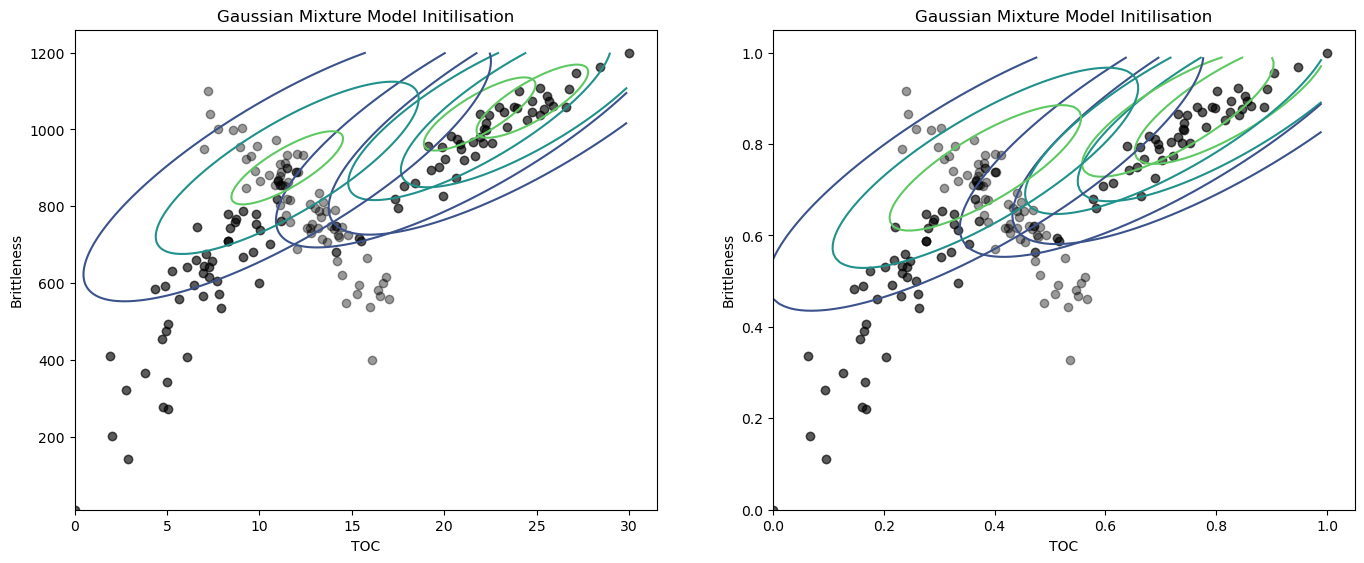

In [327]:

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c="black", alpha = 0.4, linewidths=1.0, edgecolors="black")
# Plot the Gaussian components
[means, covariances, mixing_coeffs] = initialize_parameters(X,3) #Initialise with 3 Gaussian models 
x, y = np.mgrid[np.min(X[:, 0]):np.max(X[:, 0]):.1, np.min(X[:, 1]):np.max(X[:, 1]):.1]
pos = np.dstack((x, y))
for mean, cov in zip(means, covariances):
    rv = multivariate_normal(mean, cov)
    plt.contour(x, y, rv.pdf(pos), levels=3, linewidths=1.5)

# Formatting the plot
plt.xlabel('TOC')
plt.ylabel('Brittleness')
plt.title('Gaussian Mixture Model Initilisation')

#Normalised Data
plt.subplot(122)
plt.scatter(X_norm[:, 0], X_norm[:, 1],c="black", alpha = 0.4, linewidths=1.0, edgecolors="black")
# Plot the Gaussian components
[means, covariances, mixing_coeffs] = initialize_parameters(X_norm,3) #Initialise with 3 Gaussian models 
x, y = np.mgrid[np.min(X_norm[:, 0]):np.max(X_norm[:, 0]):0.01, np.min(X_norm[:, 1]):np.max(X_norm[:, 1]):0.01]
pos = np.dstack((x, y))
for mean, cov in zip(means, covariances):
    rv = multivariate_normal(mean, cov)
    plt.contour(x, y, rv.pdf(pos), levels=3, linewidths=1.5)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

# Formatting the plot
plt.xlabel('TOC')
plt.ylabel('Brittleness')
plt.title('Gaussian Mixture Model Initilisation')
plt.show()

The figures indicate that three gaussian models were intialised randomly. Two of the models are close to each other and belong to the same cluster. 

The number of iterations is: 20


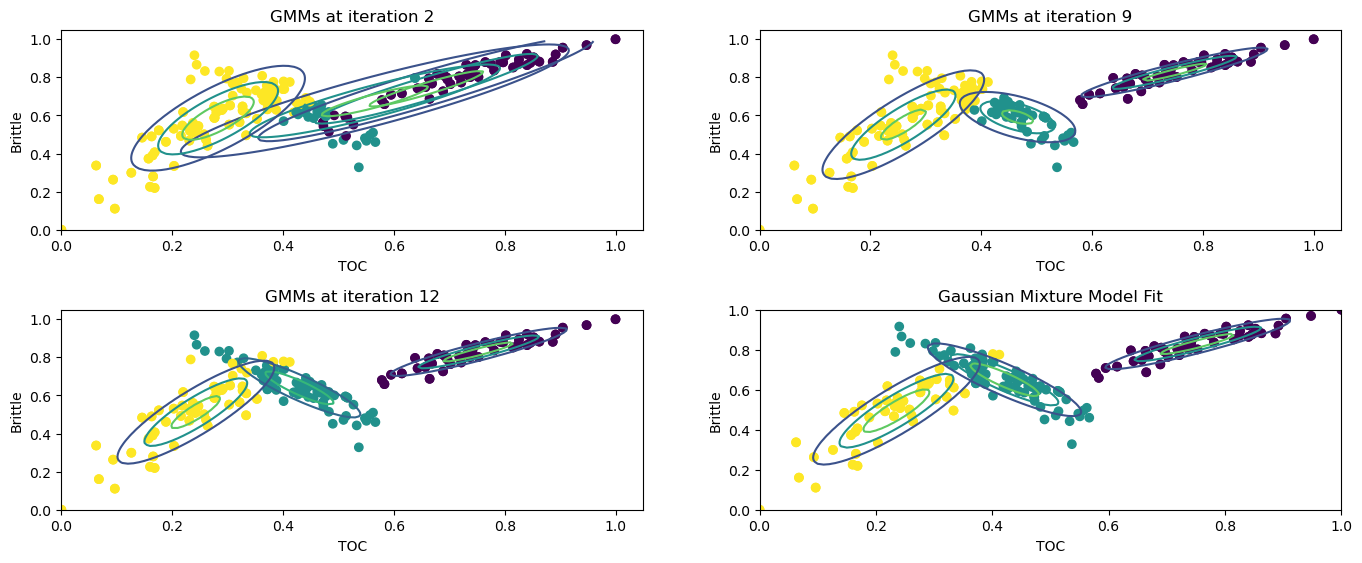

In [331]:
means, covariances, mixing_coeffs, tolerance, responsibilities = gmm_fit(X_norm, 3)

plt.subplot(224)
plt.scatter(X_norm[:, 0], X_norm[:, 1], c=responsibilities.argmax(axis=1), cmap='viridis')
# Plot the Gaussian components
x, y = np.mgrid[np.min(X_norm[:, 0]):np.max(X_norm[:, 0]):0.01, np.min(X_norm[:, 1]):np.max(X_norm[:, 1]):0.01]
pos = np.dstack((x, y))

for mean, cov in zip(means, covariances):
    rv = multivariate_normal(mean, cov)
    plt.contour(x, y, rv.pdf(pos), levels=3, linewidths=1.5)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.4)

# Formatting the plot
plt.xlim(0, 1)  
plt.ylim(0, 1)  
plt.xlabel('TOC')
plt.ylabel('Brittle')
plt.title('Gaussian Mixture Model Fit')
plt.show()

These plots show the data clustered based on the responsibilities. These plots show the clustered data based on the Gaussian models. The Gaussian Mixture Model fit is reached when there is negligible alteration in the positions of the gaussians. With our predetermined maximum iterations set to 100 and a tolerance level of 1e-4, we observe that the tolerance is achieved after 20 iterations. After analyzing the plots, it is evident that the Gaussian Mixture Models (GMMs) have effectively clustered the data.

It would be interesting explore the change between the intial Gaussian models and the updated ones in function of the iteration number. 

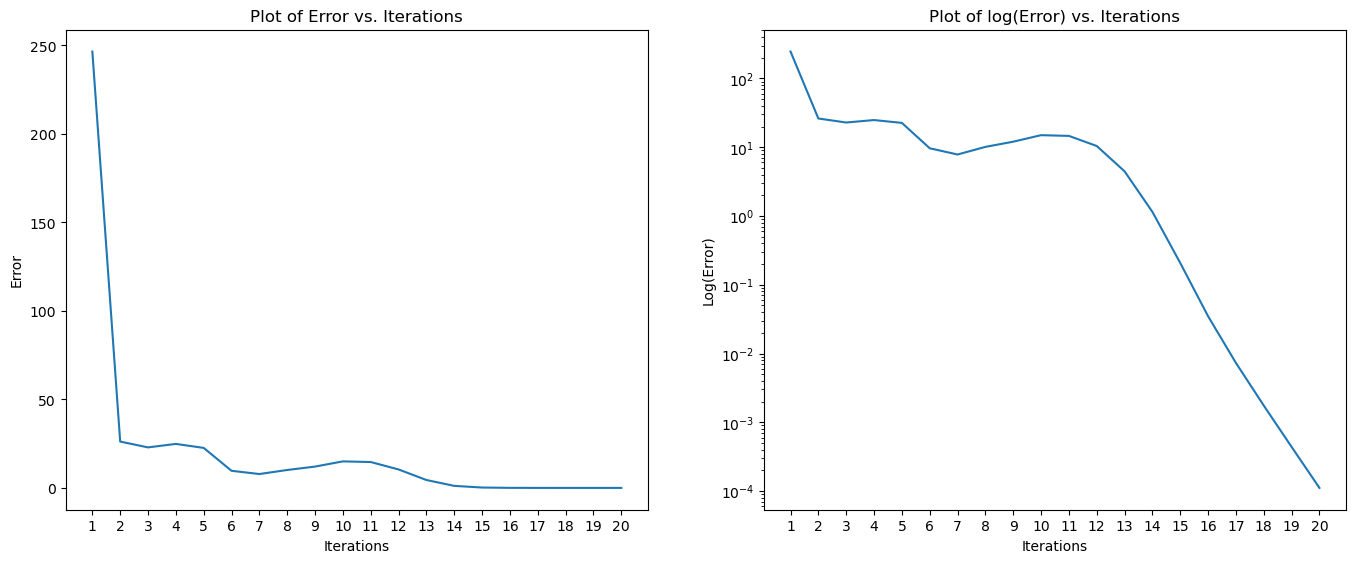

In [332]:
plt.subplot(121)
axis = np.linspace(1, 100, 100)
plt.plot( axis[:20],tolerance[:20])

# Formatting the plot
plt.xticks(np.arange(1, 21, 1))
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Plot of Error vs. Iterations')

plt.subplot(122)
axis = np.linspace(1, 100, 100)
plt.plot( axis[:20],tolerance[:20])
plt.xticks(np.arange(1, 21, 1))
plt.yscale('log')  # Set y-axis to logarithmic scale

# Formatting the plot
plt.xlabel('Iterations')
plt.ylabel('Log(Error)')
plt.title('Plot of log(Error) vs. Iterations')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

In the initial plot, the error experiences a substantial reduction right from the first iteration. It undergoes minor fluctuations until the 15th iteration, at which point it appears to stabilize, persisting in a relatively constant manner until the conclusion at the 20th iteration. Although there might be subtle changes beyond the 15th iteration, they seem to be quite negligible.
To gain a deeper insight, we visualize the error on a logarithmic scale. This reveals that the error undergoes significant variations during the early iterations, gradually diminishing as it approaches the specified tolerance of 1e-4.

### Conclusion

In this workflow, we demonstrated data clustering using Gaussian Mixture Models (GMMs). This method initialises random Gaussian Models from the data and modifies its parameters based on the responsibility that the data belong to the models. The models keep on iterating until it reaches a point where the position of the models does not change. 

### Parting Comments 

I'm Mariella El Khoury, a dedicated PhD student at the University of Texas at Austin, working in Petrophysics and formation evaluation. My enthusiasm for continuous learning led me to undertake the challenging PGE383 course. Throughout the course, particularly in the project, I stepped out of my comfort zone, and the experience significantly contributed to my growth. Moving forward, I am interested on exploring applications of Gaussian Mixture Models (GMMs) in image segmentation and NMR.

### Mariella El Khoury

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
